<a href="https://colab.research.google.com/github/purvimandot/Cyberbullying_detection/blob/master/CyberBullying_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# for model (improved version of begginer wala)
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
from collections import Counter
import numpy as np

In [ ]:
# !pip install nltk

In [ ]:

import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer
from appos import appos as APPO

nltk.download('stopwords')
nltk.download('wordnet')
eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
tk = TweetTokenizer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
path = '/content/drive/My Drive/CyberBullying_data/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'
LABELS = f'{path}test_labels.csv'

In [ ]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [ ]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)
# test_svm = pd.read_csv(TEST_DATA_FILE)
labels = pd.read_csv(LABELS)

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [ ]:
list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

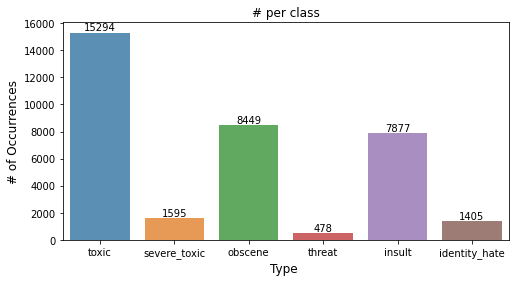

In [ ]:
import seaborn as sns
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


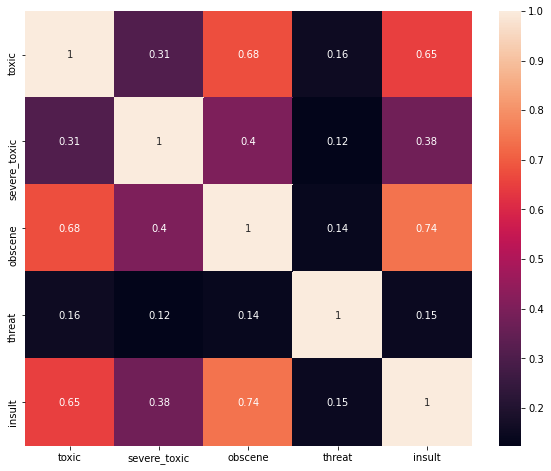

In [ ]:
temp_df=train.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

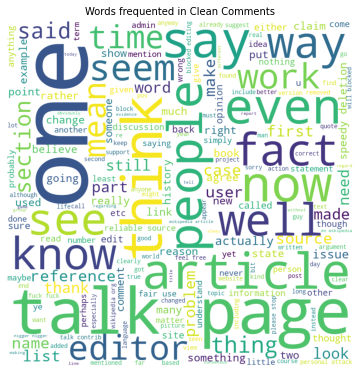

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd    
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in train.comment_text: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                      
plt.figure(figsize = (5,5), facecolor = None) 
plt.title("Words frequented in Clean Comments", fontsize=10)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


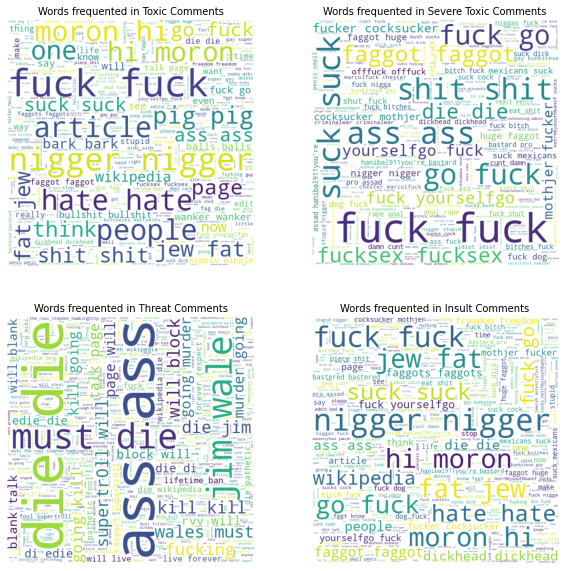

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd
plt.figure(figsize=(10,10))
plt.subplot(221)    
comment_words = '' 
stopwords = set(STOPWORDS) 
subset=train[train.toxic==1]
text=subset.comment_text.values

for val in text: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud( background_color ='white', 
                stopwords = stopwords, 
                 height=500, width =500,
                max_words=3000).generate(comment_words) 
                      
                      
plt.axis("off") 
plt.title("Words frequented in Toxic Comments", fontsize=10)
plt.imshow(wordcloud) 


plt.subplot(222)    
comment_words = '' 
stopwords = set(STOPWORDS) 
subset=train[train.severe_toxic==1]
text=subset.comment_text.values

for val in text: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud( background_color ='white', 
                stopwords = stopwords, 
                 height=500, width =500,
                max_words=3000).generate(comment_words) 
                      
# plt.figure(figsize = (5, 5), facecolor = None) 
plt.axis("off") 
plt.title("Words frequented in Severe Toxic Comments", fontsize=10)
plt.imshow(wordcloud) 
plt.subplot(223)    
comment_words = '' 
stopwords = set(STOPWORDS) 
subset=train[train.threat==1]
text=subset.comment_text.values

for val in text: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud( background_color ='white',
                      height=500, width =500, 
                stopwords = stopwords, 
                max_words=3000).generate(comment_words) 
# plt.figure(figsize = (5, 5), facecolor = None) 
plt.axis("off") 
plt.title("Words frequented in Threat Comments", fontsize=10)
plt.imshow(wordcloud) 
#plt.tight_layout(pad = 0) 

plt.subplot(224)    
comment_words = '' 
stopwords = set(STOPWORDS) 
subset=train[train.insult==1]
text=subset.comment_text.values

for val in text: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud( background_color ='white', 
                stopwords = stopwords,
                 height=500, width =500, 
                max_words=3000).generate(comment_words) 
                      
# plt.figure(figsize = (5, 5), facecolor = None) 
plt.axis("off") 
plt.title("Words frequented in Insult Comments", fontsize=10)
plt.imshow(wordcloud) 
#plt.tight_layout(pad = 0) 


plt.show() 


In [ ]:
# cleaning
corpus_train = train.iloc[:,0:2].comment_text
corpus_test = test.iloc[:,0:2].comment_text


In [107]:
train1=train
test1=test
rowsums=train1.iloc[:,2:].sum(axis=1)
train1['clean']=(rowsums==0)


In [108]:
merge=pd.concat([train1.iloc[:,0:2],test1.iloc[:,0:2]])
df=merge.reset_index(drop=True)
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
train_feats=df.iloc[0:len(train1),]
test_feats=df.iloc[len(train1):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
train_feats


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,id,comment_text,count_sent,count_word,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",3,47,0,0,0,0,0,0,True
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,3,18,0,0,0,0,0,0,True
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",3,12,0,0,0,0,0,0,True
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,1,25,0,0,0,0,0,0,True


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


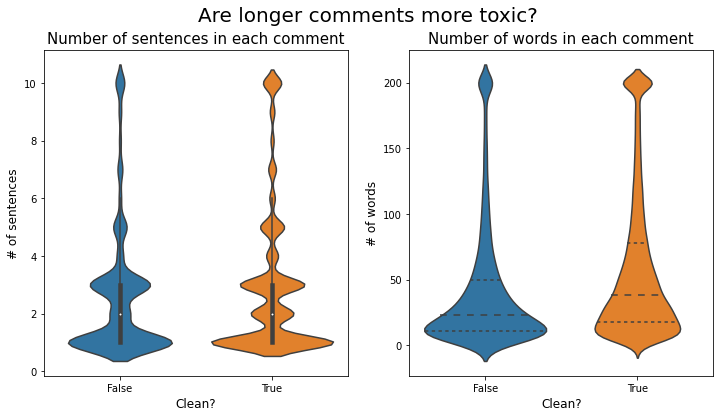

In [109]:
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

In [ ]:
def clean(comment):
    """
    Function to clean the pre-processed word lists 
    Following transformations will be done
    1) Removal of Punctuations
    2) Stop words removal from the nltk stopword list
    3) Lemmatization (Converting word to its root form : babies --> baby ; children --> child)
    """
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    comment=re.sub("\[\[.*\]","",comment)
    
    words=tk.tokenize(comment)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    return(clean_sent)

In [ ]:
rowsums=train.iloc[:,2:].sum(axis=1)
labels=(rowsums==0)
labels *= 1
labels = 1 - labels
labels
comments = train['comment_text']
labels = list(labels)
comments = list(comments)


In [ ]:
for i in range(len(comments)):
    comments[i] = clean(comments[i])

In [ ]:
pos_neg_ratios = Counter()
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()
total_vocab = Counter()
for i in range(len(comments)):
    if (labels[i] == 0):
        for word in comments[i].split(' '):
            positive_counts[word]+=1
            total_counts[word]+=1
    else:
        for word in comments[i].split(' '):
            negative_counts[word]+=1
            total_counts[word]+=1


for term,cnt in list(total_counts.most_common()):
    if cnt >1000:
        pos_neg_ratio = positive_counts[term] / float(total_counts[term])
        pos_neg_ratios[term] = pos_neg_ratio
    else:
        pos_neg_ratios[term]=0.5

for term,ratio in list(pos_neg_ratios.most_common()):
    if ratio<0.4:
        pos_neg_ratios[term]=pos_neg_ratios[term]-1.0
    if ratio>=0.4  and  ratio<=0.6:
        pos_neg_ratios[term]=0
    if pos_neg_ratios[term] !=0:
        total_vocab[term] += pos_neg_ratios[term]
vocab = set(total_vocab.keys())
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i
    
    
len(word2index)

945

In [ ]:
import torch 
import torch.nn as nn

In [ ]:
#import pytorch as torch
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(945, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)


    def forward(self, x):
        inputs = np.zeros((len(x),len(vocab)))
        
        for i in range(len(x)):
            words = []
            for word in x[i].split(" "):
                words.append(word)
            y = set(words)
            y = y.intersection(vocab)
            for i in range(len(y)):
                for word in y:
                    inputs[i][word2index[word]] = pos_neg_ratios[word]
        x = torch.tensor(inputs)
        x = x.type(torch.FloatTensor)
        x = F.relu(self.dropout1(self.fc1(x)))
        x = F.relu(self.dropout2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x*1.0
model= Classifier()

In [ ]:
from torch import nn, optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(comments, labels,stratify=labels,test_size=0.20,shuffle = True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,stratify=Y_train,test_size=0.20,shuffle = True)

In [ ]:
epochs = 2
train_losses = []
val_losses = []
val_loss= 0
min_val_loss = np.inf
import torch.nn.functional as F
for e in range(epochs):
    running_loss = 0
    model.train()
    x = X_train
    label = np.array(Y_train).astype('float32')
    label = torch.tensor(np.array(label))
    label = label.type(torch.FloatTensor)
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, label)
    running_loss = loss.item()
    loss.backward()
    optimizer.step()

    running_loss /= len(X_train)
    train_losses.append(running_loss)
    with torch.no_grad():
        model.eval()
        accuracy = 0
        val_loss = 0
        x = X_val
        log_ps = model(x)
        label = np.array(Y_val).astype('float32')
        label = torch.tensor(np.array(label))
        label = label.type(torch.FloatTensor)
        loss = criterion(log_ps, label)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        label = label.view((top_class.shape[0],top_class.shape[1]))
        equals = top_class.type(torch.FloatTensor) == label
        accuracy = torch.mean(equals.type(torch.FloatTensor))
        val_loss = loss.item() 
        val_loss /= len(X_val)
        val_losses.append(val_loss)
        print("Epochs:",e+1,"Train_loss: ",running_loss,"Valid_loss:",val_loss,"accuracy: ",accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([102124])) that is different to the input size (torch.Size([102124, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([25532])) that is different to the input size (torch.Size([25532, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epochs: 1 Train_loss:  6.6970882150187515e-06 Valid_loss: 2.613050865189476e-05 accuracy:  tensor(0.8983)
Epochs: 2 Train_loss:  6.4760326316618044e-06 Valid_loss: 2.5075682461233735e-05 accuracy:  tensor(0.8983)


In [ ]:
with torch.no_grad():
    model.eval()
    accuracy = 0
    test_loss = 0
    x = X_test
    log_ps = model(x)
    label = np.array(Y_test).astype('float32')
    label = torch.tensor(np.array(label) )
    label = label.type(torch.FloatTensor)
    loss = criterion(log_ps, label)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    label = label.view((top_class.shape[0],top_class.shape[1]))
    equals = top_class.type(torch.FloatTensor) == label
    accuracy = torch.mean(equals.type(torch.FloatTensor))
    test_loss = loss.item() 
    test_loss /= len(X_test)
    print("Test loss:",test_loss,"accuracy: ",accuracy)

Test loss: 1.9752194884053858e-05 accuracy:  tensor(0.8983)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([31915])) that is different to the input size (torch.Size([31915, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [ ]:
corpus_train.iloc[2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [ ]:
clean(corpus_train.iloc[2])

'hey man , I am really try edit war . it is guy constantly remove relevant information talk edit instead talk page . seem care format actual info .'

In [ ]:
clean_corpus_train=corpus_train.apply(lambda x :clean(x))

In [ ]:
clean_corpus_test=corpus_test.apply(lambda x :clean(x))

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(clean_corpus_train))
list_tokenized_train = tokenizer.texts_to_sequences(clean_corpus_train)

KeyboardInterrupt: ignored

In [ ]:
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

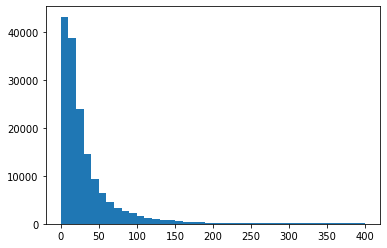

In [ ]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.020940498, 0.6441043)

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_t,y,test_size=0.10,shuffle = True)

NameError: ignored

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=2, validation_split=0.1);

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 129251 samples, validate on 14362 samples
Epoch 1/2
129251/129251 [==============================] - 629s 5ms/step - loss: 0.0607 - accuracy: 0.9788 - val_loss: 0.0506 - val_accuracy: 0.9810
Epoch 2/2
129251/129251 [==============================] - 578s 4ms/step - loss: 0.0455 - accuracy: 0.9826 - val_loss: 0.0471 - val_accuracy: 0.9818


In [ ]:
y_pred = model.predict([X_test], batch_size=1024, verbose=1)

15958/15958 [==============================] - 8s 490us/step


In [ ]:
import numpy as np
y_pred = np.asarray(y_pred)
Y_test=np.asarray(Y_test)


In [ ]:
y_pred[y_pred > .5] = 1
y_pred[y_pred < .5] = 0
y_pred=y_pred.astype(int)

In [ ]:
eval_model=model.evaluate(X_test, Y_test)
eval_model
print("Our accuracy is {}%".format((eval_model[1])*100))


15958/15958 [==============================] - 10s 635us/step
Our accuracy is 98.1660008430481%


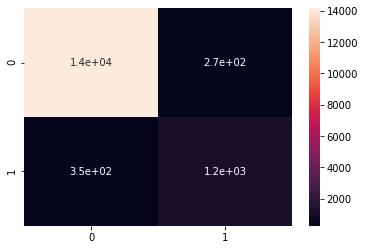

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test[:,0], y_pred[:,0])
import seaborn as sns
sns.heatmap(cm, annot=True)

In [ ]:
print(Y_test.shape)
print(y_pred.shape)

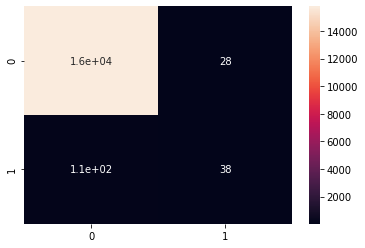

In [ ]:
cm = confusion_matrix(Y_test[:,1], y_pred[:,1])
sns.heatmap(cm, annot=True)

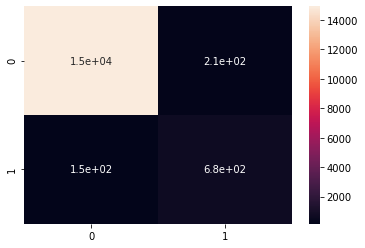

In [ ]:
cm = confusion_matrix(Y_test[:,2], y_pred[:,2])
sns.heatmap(cm, annot=True)

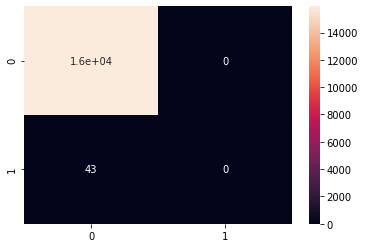

In [ ]:
cm = confusion_matrix(Y_test[:,3], y_pred[:,3])
sns.heatmap(cm, annot=True)

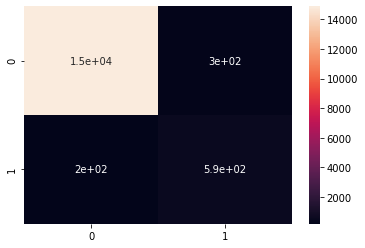

In [ ]:
cm = confusion_matrix(Y_test[:,4], y_pred[:,4])
sns.heatmap(cm, annot=True)

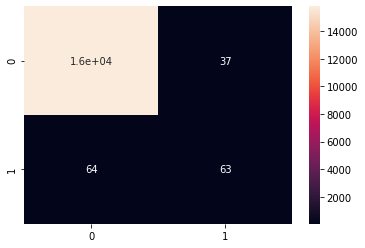

In [ ]:
cm = confusion_matrix(Y_test[:,5], y_pred[:,5])
sns.heatmap(cm, annot=True)

In [ ]:
# svm
import re, string
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize_svm(s): return re_tok.sub(r' \1 ', s).split()

In [ ]:
n = clean_corpus_train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize_svm,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(clean_corpus_train)
test_term_doc = vec.transform(clean_corpus_test)

In [ ]:
trn_term_doc, test_term_doc

In [ ]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [ ]:
x = trn_term_doc
test_x = test_term_doc

In [ ]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=1, penalty='l1', solver='liblinear')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [ ]:
preds[preds > .5] = 1
preds[preds < .5] = 0
preds=preds.astype(int)
preds

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0]])